In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

# Global Temperature Time Series Data

This data contains average land temperature data by country and state measured monthly since 1750. I received this dataset from Kaggle.
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In this post, I will be carrying out some exploratory data analysis and exploring different ways to make a time series stationary.

# Preparing the Data

Steps:
    1. Import the dataset
    2. Review what information is provided 
    3. Check for any null values
    4. Clean the data 

Step 1: Import the data

In [2]:
temp = pd.read_csv('../climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv')

Step 2: Review what information is in the dataset

In [3]:
print (temp.head())
print('')
print ('Dtypes')
print (temp.dtypes)
print('')
print ('Shape')
print (temp.shape)

           dt  AverageTemperature  AverageTemperatureUncertainty State Country
0  1855-05-01              25.544                          1.171  Acre  Brazil
1  1855-06-01              24.228                          1.103  Acre  Brazil
2  1855-07-01              24.371                          1.044  Acre  Brazil
3  1855-08-01              25.427                          1.073  Acre  Brazil
4  1855-09-01              25.675                          1.014  Acre  Brazil

Dtypes
dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
State                             object
Country                           object
dtype: object

Shape
(645675, 5)


Step 3: Check for null values

In [4]:
# Counts the number of null values in each column
temp.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

Because there are many null values, I don't want to just delete them. Instead I'm going to create dummy variables that indicate if we have temperature data for that row or not.

In [5]:
# Creating a new column indicating if we have a null value in the Avg_temp column (1) or not (0)
temp['Have_temp_data'] = temp['AverageTemperature'].apply(lambda x: 1 if not pd.isnull(x) else 0)
temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country,Have_temp_data
0,1855-05-01,25.544,1.171,Acre,Brazil,1
1,1855-06-01,24.228,1.103,Acre,Brazil,1
2,1855-07-01,24.371,1.044,Acre,Brazil,1
3,1855-08-01,25.427,1.073,Acre,Brazil,1
4,1855-09-01,25.675,1.014,Acre,Brazil,1


In [6]:
# Verifying all null values have 0 
temp['Have_temp_data'].value_counts()

1    620027
0     25648
Name: Have_temp_data, dtype: int64

In [7]:
# Null values by country
temp['Have_temp_data'].groupby(temp['Country']).value_counts()

Country        Have_temp_data
Australia      1                  15905
               0                    197
Brazil         1                  32451
               0                   1877
Canada         1                  32146
               0                   3212
China          1                  67726
               0                    780
India          1                  81620
               0                   5044
Russia         1                 248249
               0                   6723
United States  1                 141930
               0                   7815
Name: Have_temp_data, dtype: int64

Step 4: Cleaning the data

In [8]:
# I want to rename the column names so they are more concise
temp.rename(columns={'dt':'Date', 'AverageTemperature':'Avg_temp', 'AverageTemperatureUncertainty':'Temp_confidence_interval'}, inplace=True)
temp.head()

,Date,Avg_temp,Temp_confidence_interval,State,Country,Have_temp_data
0,1855-05-01,25.544,1.171,Acre,Brazil,1
1,1855-06-01,24.228,1.103,Acre,Brazil,1
2,1855-07-01,24.371,1.044,Acre,Brazil,1
3,1855-08-01,25.427,1.073,Acre,Brazil,1
4,1855-09-01,25.675,1.014,Acre,Brazil,1


In [9]:
# Convert the date column to datetime series
temp['Date'] = pd.to_datetime(temp['Date'])
temp.set_index('Date', inplace=True)
temp.index

DatetimeIndex(['1855-05-01', '1855-06-01', '1855-07-01', '1855-08-01',
               '1855-09-01', '1855-10-01', '1855-11-01', '1855-12-01',
               '1856-01-01', '1856-02-01',
               ...
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='Date', length=645675, freq=None)

In [10]:
# I want to extract just the year from the date column and create it's own column.
temp['Year'] = temp.index.year
temp.head()

,Avg_temp,Temp_confidence_interval,State,Country,Have_temp_data,Year
Date,,,,,,
1855-05-01,25.544,1.171,Acre,Brazil,1,1855
1855-06-01,24.228,1.103,Acre,Brazil,1,1855
1855-07-01,24.371,1.044,Acre,Brazil,1,1855
1855-08-01,25.427,1.073,Acre,Brazil,1,1855
1855-09-01,25.675,1.014,Acre,Brazil,1,1855


In [11]:
# Reviewing if there's null values in the last years of the data grouped by Year
temp['Have_temp_data'].groupby(temp.index.year).value_counts().tail(45)

Date  Have_temp_data
1970  1                 2892
1971  1                 2892
1972  1                 2892
1973  1                 2892
1974  1                 2892
1975  1                 2892
1976  1                 2892
1977  1                 2892
1978  1                 2892
1979  1                 2892
1980  1                 2892
1981  1                 2892
1982  1                 2892
1983  1                 2892
1984  1                 2892
1985  1                 2892
1986  1                 2892
1987  1                 2892
1988  1                 2892
1989  1                 2892
1990  1                 2892
1991  1                 2892
1992  1                 2892
1993  1                 2892
1994  1                 2892
1995  1                 2892
1996  1                 2892
1997  1                 2892
1998  1                 2892
1999  1                 2892
2000  1                 2892
2001  1                 2892
2002  1                 2892
2003  1               

It seems that most of the null values are not found towards the end of the time series data (except in 2013 where there are a handful). I'm going to analyze the data based on the years 1970-2013.

# Analyzing the Data

Steps:
    1. Structure the data
    2. Visualize the data
    3. Complete analysis of the data

Step 1: Structure the data

In [12]:
# Statistical information by column
temp.describe()

,Avg_temp,Temp_confidence_interval,Have_temp_data,Year
count,620027.000000,620027.000000,645675.000000,645675.000000
mean,8.993111,1.287647,0.960277,1898.295178
std,13.772150,1.360392,0.195307,69.907443
min,-45.389000,0.036000,0.000000,1743.000000
25%,-0.693000,0.316000,1.000000,1845.000000
50%,11.199000,0.656000,1.000000,1902.000000
75%,19.899000,1.850000,1.000000,1957.000000
max,36.339000,12.646000,1.000000,2013.000000


In [13]:
# Filtering by years 1970-2013 because these didn't have many null values
recent_temp = temp.loc['1970':'2013']
recent_temp.head()

,Avg_temp,Temp_confidence_interval,State,Country,Have_temp_data,Year
Date,,,,,,
1970-01-01,26.363,0.382,Acre,Brazil,1,1970
1970-02-01,26.280,0.472,Acre,Brazil,1,1970
1970-03-01,25.825,0.285,Acre,Brazil,1,1970
1970-04-01,26.120,0.306,Acre,Brazil,1,1970
1970-05-01,26.447,1.218,Acre,Brazil,1,1970


In [14]:
#  Statistical information by country
recent_temp.groupby('Country').describe()

Avg_temp                                                  \
                 count       mean        std     min       25%     50%   
Country                                                                  
Australia       4192.0  18.355139   6.859765   3.777  12.71275  17.927   
Brazil          8384.0  24.427653   3.085458  11.246  23.04375  25.453   
Canada          6299.0  -0.895228  13.195024 -38.806 -10.32650   1.260   
China          16244.0  12.043840  11.403221 -26.593   4.63175  13.680   
India          17816.0  22.792810   7.855764 -10.407  19.19325  25.511   
Russia         46636.0   2.260807  13.093572 -44.586  -6.88700   3.704   
United States  26773.0  11.369874  10.141992 -27.057   3.82800  12.175   

                                Have_temp_data             ...    \
                    75%     max          count      mean   ...     
Country                                                    ...     
Australia      24.25950  32.214         4200.0  0.998095   ...     
Brazil         26.54125  29.559         8400.0  0.998095   ...     
Canada         10.11500  20.603         6300.0  0.999841   ...     
China          21.36325  30.666        16275.0  0.998095   ...     
India          27.99875  36.339        17850.0  0.998095   ...     
Russia         13.36325  29.501        46725.0  0.998095   ...     
United States  19.92900  32.200        26775.0  0.999925   ...     

              Temp_confidence_interval            Year               \
                                   75%    max    count         mean   
Country                                                               
Australia                      0.26000  0.636   4200.0  1991.377143   
Brazil                         0.44625  1.553   8400.0  1991.377143   
Canada                         0.38400  4.786   6300.0  1991.377143   
China                          0.29600  1.496  16275.0  1991.377143   
India                          0.44100  1.946  17850.0  1991.377143   
Russia                         0.36200  5.435  46725.0  1991.377143   
United States                  0.26400  1.322  26775.0  1991.377143   

                                                                  
                     std     min     25%     50%     75%     max  
Country                                                           
Australia      12.631425  1970.0  1980.0  1991.0  2002.0  2013.0  
Brazil         12.630673  1970.0  1980.0  1991.0  2002.0  2013.0  
Canada         12.630924  1970.0  1980.0  1991.0  2002.0  2013.0  
China          12.630309  1970.0  1980.0  1991.0  2002.0  2013.0  
India          12.630275  1970.0  1980.0  1991.0  2002.0  2013.0  
Russia         12.630056  1970.0  1980.0  1991.0  2002.0  2013.0  
United States  12.630157  1970.0  1980.0  1991.0  2002.0  2013.0  

[7 rows x 32 columns]

In [15]:
# Shows the average temperature by country in descending order
recent_temp[['Country','Avg_temp']].groupby(['Country']).mean().sort_values('Avg_temp',ascending=False)

,Avg_temp
Country,
Brazil,24.427653
India,22.792810
Australia,18.355139
China,12.043840
United States,11.369874
Russia,2.260807
Canada,-0.895228


Step 2: Visualize the time series

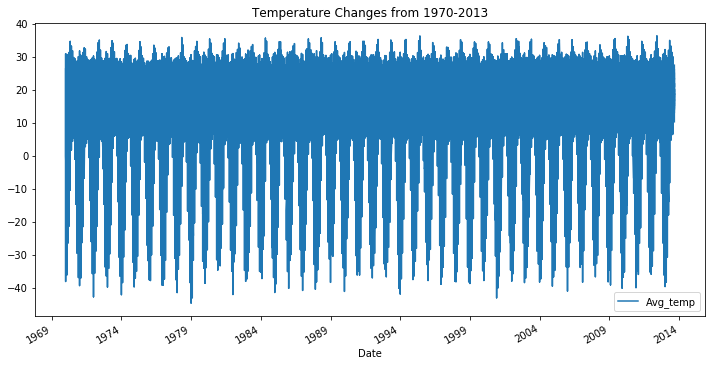

In [16]:
recent_temp[['Avg_temp']].plot(kind='line',title='Temperature Changes from 1970-2013',figsize=(12,6))

Step 3: Complete analysis of the time series

Here I'm going to review how to determine if a time seriees is stationary and if it isn't, then list a few ways to make the series stationary.

Steps:

    a) Resample the time series to create a more distinct line

    b) Test stationary with the Dickey-Fuller Test 

    c) Transform the data to make it stationary, if needed 

    d) Review SARIMA with ACF and PACF

Step 3a: Resample the time series

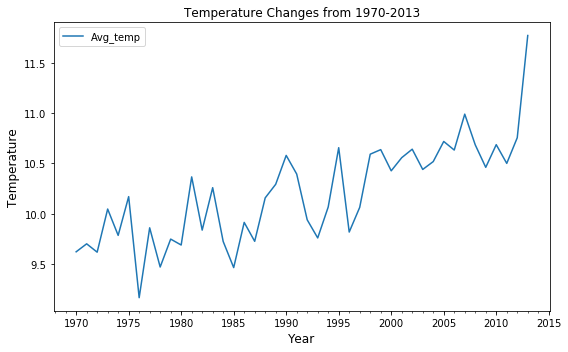

In [17]:
# Resampling annual averages 
temp_resamp = recent_temp[['Avg_temp']].resample('A').mean()

# Temperature graph 
temp_resamp.plot(title='Temperature Changes from 1970-2013',figsize=(8,5))
plt.ylabel('Temperature',fontsize=12)
plt.xlabel('Year',fontsize=12)
plt.legend()

plt.tight_layout()

Step 3b: Dickey-Fuller Test

The Dickey-Fuller test determines how stationary a time series is. If trends affect the time series (i.e. the mean or variance is not constant), then it is not stationary. This test will show stationary with the Test Statistic less than the critical value.

The null hypothesis is that the time series is not stationary and is affected by trends.

In [18]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print ('Dickey-Fuller Test Results:')
dftest = adfuller(temp_resamp.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Dickey-Fuller Test Results:
Test Statistic                  0.811219
p-value                         0.991815
#Lags Used                      8.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


The Test Statstic is greater than the critical value. Therefore, we have failed to reject the null hypothesis at this point. 

We can visualize that the time series isn't stationary yet by separating the trend component.

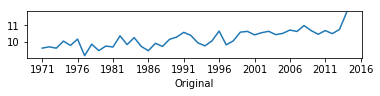

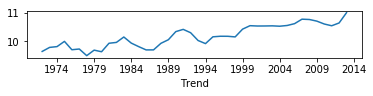

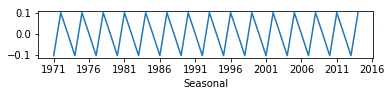

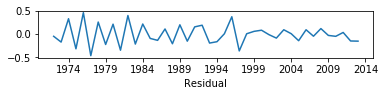

<Figure size 432x288 with 0 Axes>

In [19]:
# Decomposing the data
temp_decomp = seasonal_decompose(temp_resamp, freq=3)  

# Extracting the components
trend = temp_decomp.trend
seasonal = temp_decomp.seasonal
residual = temp_decomp.resid

# Plotting the original time series
plt.subplot(411)
plt.plot(temp_resamp)
plt.xlabel('Original')
plt.figure(figsize=(6,4))

# Plotting the trend component
plt.subplot(412)
plt.plot(trend)
plt.xlabel('Trend')
plt.figure(figsize=(6,4))

# Plotting the seasonal component
plt.subplot(413)
plt.plot(seasonal)
plt.xlabel('Seasonal')
plt.figure(figsize=(6,4))

# Plotting the residual component
plt.subplot(414)
plt.plot(residual)
plt.xlabel('Residual')
plt.figure(figsize=(6,4))

plt.tight_layout()

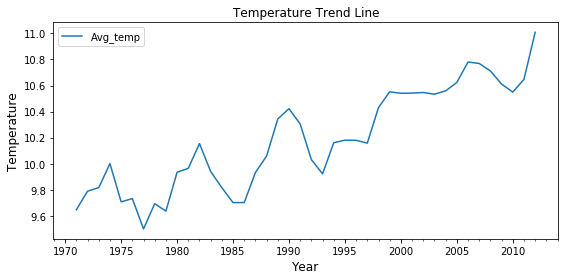

In [20]:
# Graphing just the trend line 
trend.plot(title='Temperature Trend Line',figsize=(8,4)) 

# Graph labels
plt.xlabel('Year',fontsize=12)
plt.ylabel('Temperature',fontsize=12)

plt.tight_layout()

The increasing trend line in the decomposition proves that this data currently isn't stationary. We want the trend line to be constant over time.

Step 3c: Transformation

There are a few ways to use transformation to make the data stationary:
    1. Moving average 
    2. Exponential smoothing 
    3. Shifting  
    4. Discomposing the residuals

I'm going to first compare the transformation using both the moving average (rolling mean) and exponential smoothing. The rolling mean will take a window of "k" values and average them. The exponentially weighted mean uses "exponential decay" which decreases the weight of the previous means over time. 

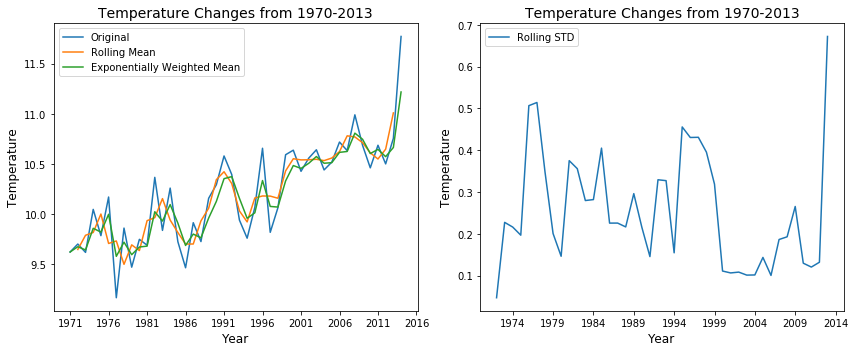

In [21]:
# Rolling mean 
temp_rol_mean = temp_resamp.rolling(window=3, center=True).mean()

# Exponentially weighted mean 
temp_ewm = temp_resamp.ewm(span=3).mean()

# Rolling standard deviation 
temp_rol_std = temp_resamp.rolling(window=3, center=True).std()

# Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Temperature graph with rolling mean and exponentially weighted mean
ax1.plot(temp_resamp,label='Original')
ax1.plot(temp_rol_mean,label='Rolling Mean')
ax1.plot(temp_ewm, label='Exponentially Weighted Mean')
ax1.set_title('Temperature Changes from 1970-2013',fontsize=14)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

# Temperature graph with rolling STD 
ax2.plot(temp_rol_std,label='Rolling STD')
ax2.set_title('Temperature Changes from 1970-2013',fontsize=14)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

In [22]:
# Dickey-Fuller test 
temp_rol_mean.dropna(inplace=True)
temp_ewm.dropna(inplace=True)
print ('Dickey-Fuller Test for the Rolling Mean:')
dftest = adfuller(temp_rol_mean.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print ('')
print ('Dickey-Fuller Test for the Exponentially Weighted Mean:')
dftest = adfuller(temp_ewm.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Dickey-Fuller Test for the Rolling Mean:
Test Statistic                  0.833452
p-value                         0.992157
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64

Dickey-Fuller Test for the Exponentially Weighted Mean:
Test Statistic                  1.292315
p-value                         0.996566
#Lags Used                      7.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


Here both test statistics are greater than the critical values, so we have failed to reject the null hypothesis.

We can use differencing to remove the moving average or exponentially weighted mean from the original time series. We can then drop any rows that are N/A.

In [23]:
# Difference between the original and the rolling mean 
diff_rol_mean = temp_resamp - temp_rol_mean
diff_rol_mean.dropna(inplace=True)
diff_rol_mean.head()

,Avg_temp
Date,
1971-12-31,0.054093
1972-12-31,-0.170497
1973-12-31,0.230047
1974-12-31,-0.215531
1975-12-31,0.462950


In [24]:
# Difference between the original and the exponentially weighted mean
diff_ewm = temp_resamp - temp_ewm
diff_ewm.dropna(inplace=True)
diff_ewm.head()

,Avg_temp
Date,
1970-12-31,0.000000
1971-12-31,0.026423
1972-12-31,-0.024251
1973-12-31,0.188640
1974-12-31,-0.035333


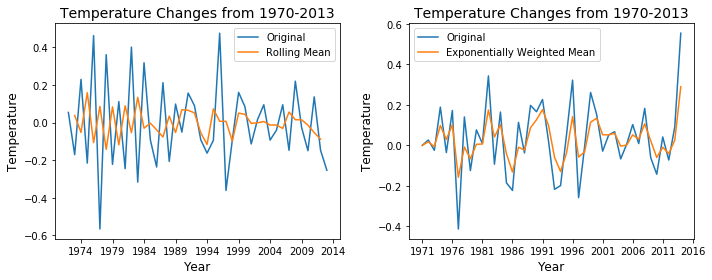

In [26]:
# Rolling mean of the difference
temp_rol_mean_diff = diff_rol_mean.rolling(window=3, center=True).mean()

# Expotentially weighted mean of the difference
temp_ewm_diff = diff_ewm.ewm(span=3).mean()

# Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Difference graph with the rolling mean
ax1.plot(diff_rol_mean,label='Original')
ax1.plot(temp_rol_mean_diff,label='Rolling Mean')
ax1.set_title('Temperature Changes from 1970-2013',fontsize=14)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

# Difference graph with the exponentially weighted mean
ax2.plot(diff_ewm,label='Original')
ax2.plot(temp_ewm_diff,label='Exponentially Weighted Mean')
ax2.set_title('Temperature Changes from 1970-2013',fontsize=14)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()

In [27]:
# Dickey-Fuller test 
print ('Dickey-Fuller Test for the Difference between the Original and Rolling Mean:')
dftest = adfuller(diff_rol_mean.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print ('')
print ('Dickey-Fuller Test for the Difference between the Original and Exponentially Weighted Mean:')
dftest = adfuller(diff_ewm.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Dickey-Fuller Test for the Difference between the Original and Rolling Mean:
Test Statistic                 -5.423400
p-value                         0.000003
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

Dickey-Fuller Test for the Difference between the Original and Exponentially Weighted Mean:
Test Statistic                 -4.363016
p-value                         0.000345
#Lags Used                      6.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


The test statistic is less than the critial value for both the rolling mean and exponentially weighted mean, indicating that we can reject the null hypothesis. We can be 99% confident that this data is stationary.

A third way to remove the trend is by shifting values. 

In [30]:
# Shifting forward by 1 year
temp_shift1 = temp_resamp.shift(1)
temp_shift1.head()

,Avg_temp
Date,
1970-12-31,NaN
1971-12-31,9.622481
1972-12-31,9.701750
1973-12-31,9.618741
1974-12-31,10.047222


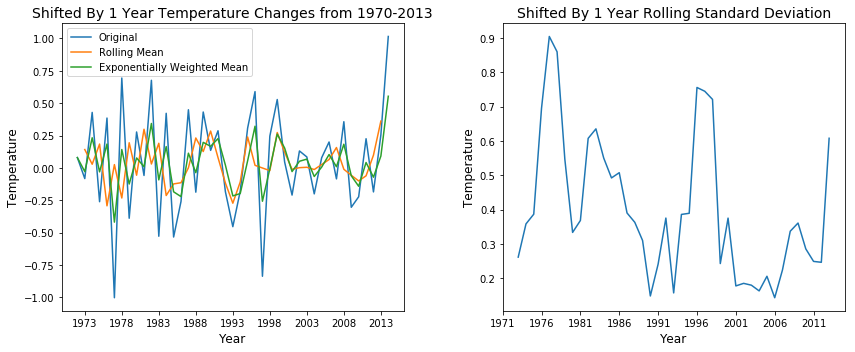

In [31]:
# Difference between the original and time series shifted by 1 year 
shift1_diff = temp_resamp - temp_shift1
shift1_diff.dropna(inplace=True)

# Rolling mean 
temp_shift1_diff_rol_mean = shift1_diff.rolling(window=3, center=True).mean()

# Exponentially weighted mean 
temp_shift1_diff_ewm = shift1_diff.ewm(span=3).mean()

# Rolling standard deviation 
temp_shift1_diff_rol_std = shift1_diff.rolling(window=3, center=True).std()

# Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Temperature graph 
ax1.plot(shift1_diff,label='Original')
ax1.plot(temp_shift1_diff_rol_mean,label='Rolling Mean')
ax1.plot(temp_shift1_diff_ewm,label='Exponentially Weighted Mean')
ax1.set_title('Shifted By 1 Year Temperature Changes from 1970-2013',fontsize=14)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

# Temperature Rolling STD graph
ax2.plot(temp_shift1_diff_rol_std)
ax2.set_title('Shifted By 1 Year Rolling Standard Deviation',fontsize=14)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
# Dickey-Fuller test 
print ('Dickey-Fuller Test for Difference between the Original and Shifted by 1 Year:')
dftest = adfuller(shift1_diff.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Dickey-Fuller Test for Difference between the Original and Shifted by 1 Year:
Test Statistic                 -4.663677
p-value                         0.000098
#Lags Used                      7.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


We can reject the null hypothesis because the test statistic is less than the critical value. We can be 99% confident that this data is stationary.

A fourth way is to decompose the time series to extract just the residual component (and remove the trend and seasonality components). I had already decomposed the time series in step 3b, so I will graph just the residuals.

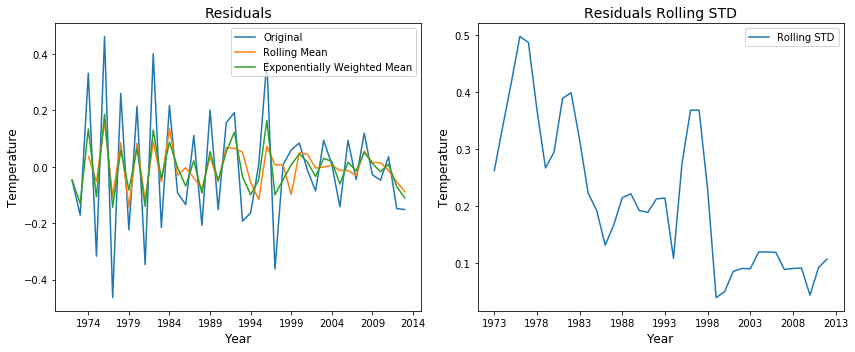

In [34]:
# Drop N/A values
residual.dropna(inplace=True)

# Residuals rolling mean
resid_rol_mean = residual.rolling(window=3).mean()

# Residuals exponentially weighted mean
resid_ewm = residual.ewm(span=3).mean()

# Residuals rolling standard deviation 
resid_rol_std = residual.rolling(window=3, center=True).std()

# Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Temperature graph with residual rolling mean and exponentially weighted mean
ax1.plot(residual,label='Original')
ax1.plot(resid_rol_mean,label='Rolling Mean')
ax1.plot(resid_ewm, label='Exponentially Weighted Mean')
ax1.set_title('Residuals',fontsize=14)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

# Temperature graph with residual rolling STD 
ax2.plot(resid_rol_std,label='Rolling STD')
ax2.set_title('Residuals Rolling STD',fontsize=14)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

In [35]:
# Dickey-Fuller test 
print ('Dickey-Fuller Test for the Residuals:')
dftest = adfuller(residual.iloc[:,0].values, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Dickey-Fuller Test for the Residuals:
Test Statistic                 -4.773733
p-value                         0.000061
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


We can see that the test statistic is less than the critical values, therefore we can reject the null hypothesis.

Step 3d: SARIMA 

Here I'll review how you can find the parameters for the Seasonal Autoregressive Integrated Moving Average (SARIMA) which forecasts a time series similarly to linear regression and has parameters (p,d,q) (P,D,Q). The first set of parameters (p,d,q) is applied to the non-seasonal portion of the time series while the second set (P,D,Q) is applied to the seasonal portion of the time series.

The parameters are broken down as:    
1. Autoregressive (p): looks at the past values. I.e., if the temperature increased over the past 3 years, it's most likely to increase next year as well.
2. Integrated (d): looks at the difference between the past values and the current value. I.e., if the temperature differed little over the past 3 years, then it's most likely to be the same temperature next year.
3. Moving average (q): uses a linear combination of errors in past values for the predicted error of the model (errors being the difference between the moving average and actual values). I.e., for q=5, x(t) is e(t-1)...e(t-5).

To determine the p and q parameters, we can use autocorrelation function (ACF) and partial autocorrelation function (PACF).

/Users/micheweber/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


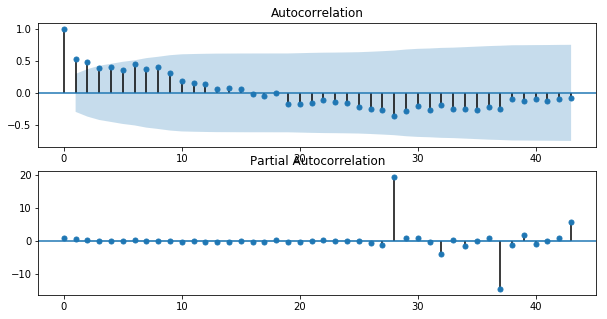

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

# Plotting the autocorrelation and partial autocorrelation graphs
pyplot.figure(figsize=(10,5))
pyplot.subplot(211)
plot_acf(temp_resamp, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(temp_resamp, ax=pyplot.gca())
pyplot.show()

The p parameter will be the first value on the Partial Autocorrelation graph that is signficantly different from the previous values. Here, p could be 28.

The q parameter is the largest lag on the Autocorrelation plot that is significantly differeent from the previous values. Here, q could be 0 as there are no signficant lags.

Next, the d parameter will be the number of differences taken to make the time series stationary. For example, d could be 1 when using one of the transformations above.

You can then apply this logic to the seasonality parameters (P,D,Q)!

# Conclusion

We showed how to brielfy explore some temperature time series data and then broke down how we can identify if the series is stationary or not by using the Dickey-Fuller Test.

If a time series data is not stationary, then some ways we can make it stationary is with:
    1. Moving average
    2. Exponential smoothing
    3. Shifting
    4. Decomposing the residuals

We can then use SARIMA to forecast the time series data.